In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer, SentencePieceBPETokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

# Configuration
EPOCHS = 3
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
MAX_LEN = 128

# Create fast tokenizer

In [5]:
# First load the real tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('t5-large')
tokenizer.pad_token = tokenizer.eos_token
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
# fast_tokenizer = SentencePieceBPETokenizer('vocab.txt')
# fast_tokenizer

('./spiece.model', './special_tokens_map.json', './added_tokens.json')

# Load text data into memory


In [6]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')


In [7]:
train1.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
olid = pd.read_csv('/kaggle/input/olid2019/olid-training-v1.0.tsv', sep='\t')
olid = olid.rename(columns={"id": "id", "tweet": "comment_text", 'subtask_a': 'toxic'})
olid.toxic = (olid.toxic == 'OFF').astype(int)
olid['comment_text'] = olid['comment_text'].str.replace('@USER', '')
olid.head()

,id,comment_text,toxic,subtask_b,subtask_c
0,86426,She should ask a few native Americans what th...,1,UNT,NaN
1,90194,Go home you’re drunk!!! #MAGA #Trump2020 👊🇺...,1,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,0,NaN,NaN
3,62688,"Someone should'veTaken"" this piece of shit to...",1,UNT,NaN
4,43605,Obama wanted liberals &amp; illegals to move...,0,NaN,NaN


In [9]:
from sklearn.model_selection import train_test_split
olid_train, olid_test = train_test_split(olid, test_size=3240, random_state = 2020)
olid_train_1k = olid_train[0:1000]
olid_train_2k = olid_train[0:2000]
olid_train_5k = olid_train[0:5000]

In [10]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)
])

In [11]:
train.toxic.value_counts()

0    352165
1    133610
Name: toxic, dtype: int64

In [12]:
def fast_encode_xlm(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.batch_encode_plus(text_chunk, pad_to_max_length = True, max_length = maxlen)
        all_ids.extend(np.array(encs.input_ids))
    
    return np.array(all_ids)

In [13]:
x_train = fast_encode_xlm(train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode_xlm(valid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
x_test = fast_encode_xlm(test.content.astype(str), tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

In [14]:
# olid_encode = fast_encode_xlm(olid.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_encode = fast_encode_xlm(olid_train.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_1k_encode = fast_encode_xlm(olid_train_1k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_2k_encode = fast_encode_xlm(olid_train_2k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_train_5k_encode = fast_encode_xlm(olid_train_5k.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)
olid_test_encode = fast_encode_xlm(olid_test.comment_text.astype(str), tokenizer, maxlen=MAX_LEN)

In [15]:
y_olid_train = olid_train.toxic.values
y_olid_train_1k = olid_train_1k.toxic.values
y_olid_train_2k = olid_train_2k.toxic.values
y_olid_train_5k = olid_train_5k.toxic.values
y_olid_test = olid_test.toxic.values


# Build datasets objects

In [16]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [17]:
olid_test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(olid_test_encode)
    .batch(BATCH_SIZE)
)

olid_test_dataset_wlabel = (
    tf.data.Dataset
    .from_tensor_slices((olid_test_encode, y_olid_test))
    .batch(BATCH_SIZE)
)
olid_train_1k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_1k_encode, y_olid_train_1k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_2k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_2k_encode, y_olid_train_2k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_5k_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_5k_encode, y_olid_train_5k))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
olid_train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((olid_train_encode, y_olid_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Load model into the TPU


In [18]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids, decoder_input_ids=input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [19]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFT5Model.from_pretrained('t5-large')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_t5model (TFT5Model)       ((None, 128, 1024), (((No 737668608 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 737,669,633
Trainable params: 737,669,633
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 21s, sys: 33.9 s, total: 2min 55s
Wall time: 2min 48s


# Train Model

In [20]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=1
)

7590/7590 [==============================] - 2948s 388ms/step - loss: 0.0773 - accuracy: 0.9698 - val_loss: 0.7847 - val_accuracy: 0.8458


In [21]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=1
)

125/125 [==============================] - 47s 374ms/step - loss: 0.3639 - accuracy: 0.8546


# Submission

In [22]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)


998/998 [==============================] - 92s 92ms/step


In [23]:
sub.describe()

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.126965
std,18421.082026,0.182134
min,0.000000,0.000103
25%,15952.750000,0.011645
50%,31905.500000,0.046829
75%,47858.250000,0.157977
max,63811.000000,0.997589


# Olid

In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
olid_test.toxic_predict = model.predict(olid_test_dataset, verbose=1)
olid_test.to_csv('olid_test_0shot.csv', index=False)

roc_auc_score(y_true = olid_test.toxic, y_score = olid_test.toxic_predict)

51/51 [==============================] - 17s 331ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


0.8198747443491898

In [26]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, log_loss, f1_score
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(olid_test.toxic, olid_test.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test.toxic_predict]

the optimal threshold is 0.15630319714546204


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [27]:
f1_score(y_true = olid_test.toxic, y_pred = olid_test.toxic_predict_binary)


0.6674767112191171

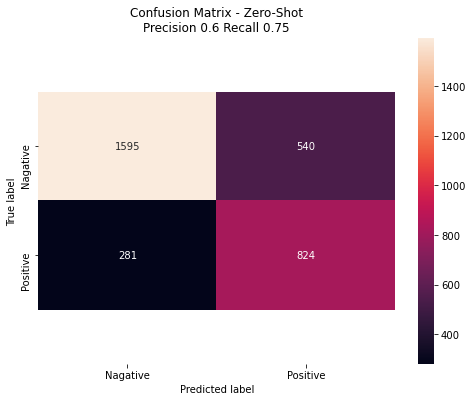

In [28]:
def plot_matrix(target, predicted_binary, name):
    matrix = confusion_matrix(target, predicted_binary)
    TN, FP, FN, TP = matrix.ravel()
    if (TP + FP > 0) and (TP + FN > 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F =  2 * (precision*recall) / (precision + recall)
    else:
        F = 0
    cm_df = pd.DataFrame(matrix,
                         index = ['Nagative', 'Positive'], 
                         columns = ['Nagative', 'Positive'])
    subtitle = 'Precision ' + str(round(precision, 2)) + ' Recall ' + str(round(recall, 2))
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix - ' + name + "\n" + subtitle)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_matrix(olid_test.toxic, olid_test.toxic_predict_binary, name = 'Zero-Shot')


# Olid Few-shot

In [29]:
model_1k = model
model_1k.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
n_steps = olid_train_1k.shape[0] // BATCH_SIZE
train_history_1k = model_1k.fit(
    olid_train_1k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_test_dataset_wlabel,
    epochs=5
)

olid_test1k = olid_test
olid_test1k.toxic_predict = model_1k.predict(olid_test_dataset, verbose=1)
olid_test1k.to_csv('olid_test_1k.csv', index=False)

print('1k roc is ' + str(roc_auc_score(y_true = olid_test1k.toxic, y_score = olid_test1k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test1k.toxic, olid_test1k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test1k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test1k.toxic_predict]

print('1k f1-score is ' + str(f1_score(y_true = olid_test1k.toxic, y_pred = olid_test1k.toxic_predict_binary)))

del model_1k

Epoch 1/5
15/15 [==============================] - 61s 4s/step - loss: 0.4836 - accuracy: 0.8115 - val_loss: 0.5272 - val_accuracy: 0.7769
Epoch 2/5
15/15 [==============================] - 10s 675ms/step - loss: 0.4689 - accuracy: 0.8088 - val_loss: 0.5117 - val_accuracy: 0.7821
Epoch 3/5
15/15 [==============================] - 10s 669ms/step - loss: 0.4529 - accuracy: 0.8034 - val_loss: 0.5032 - val_accuracy: 0.7809
Epoch 4/5
15/15 [==============================] - 10s 675ms/step - loss: 0.4538 - accuracy: 0.8013 - val_loss: 0.4976 - val_accuracy: 0.7812
Epoch 5/5
51/51 [==============================] - 4s 80ms/step
1k roc is 0.830124089989085
the optimal threshold is 0.2960119843482971
1k f1-score is 0.6837606837606838


In [30]:
model_2k = model
model_2k.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
n_steps = olid_train_2k.shape[0] // BATCH_SIZE
train_history_2k = model_2k.fit(
    olid_train_2k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_test_dataset_wlabel,
    epochs=5
)

olid_test2k = olid_test
olid_test2k.toxic_predict = model_2k.predict(olid_test_dataset, verbose=1)
olid_test2k.to_csv('olid_test_2k.csv', index=False)

print('2k roc is ' + str(roc_auc_score(y_true = olid_test2k.toxic, y_score = olid_test2k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test2k.toxic, olid_test2k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test2k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test2k.toxic_predict]

print('2k f1-score is ' + str(f1_score(y_true = olid_test2k.toxic, y_pred = olid_test2k.toxic_predict_binary)))

del model_2k

Epoch 1/5
31/31 [==============================] - 67s 2s/step - loss: 0.4427 - accuracy: 0.8044 - val_loss: 0.4842 - val_accuracy: 0.7843
Epoch 2/5
31/31 [==============================] - 17s 533ms/step - loss: 0.4265 - accuracy: 0.8058 - val_loss: 0.4778 - val_accuracy: 0.7861
Epoch 3/5
31/31 [==============================] - 16s 527ms/step - loss: 0.4197 - accuracy: 0.8125 - val_loss: 0.4736 - val_accuracy: 0.7843
Epoch 4/5
31/31 [==============================] - 16s 526ms/step - loss: 0.4252 - accuracy: 0.8125 - val_loss: 0.4711 - val_accuracy: 0.7849
Epoch 5/5
51/51 [==============================] - 4s 81ms/step
2k roc is 0.8438449881844288
the optimal threshold is 0.31784749031066895
2k f1-score is 0.6993865030674846


In [31]:
model_5k = model
model_5k.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
n_steps = olid_train_5k.shape[0] // BATCH_SIZE
train_history_5 = model_5k.fit(
    olid_train_5k_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_test_dataset_wlabel,
    epochs=5
)

olid_test5k = olid_test
olid_test5k.toxic_predict = model_5k.predict(olid_test_dataset, verbose=1)
olid_test5k.to_csv('olid_test_5k.csv', index=False)

print('5k roc is ' + str(roc_auc_score(y_true = olid_test5k.toxic, y_score = olid_test5k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test5k.toxic, olid_test5k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test5k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test5k.toxic_predict]

print('5k f1-score is ' + str(f1_score(y_true = olid_test5k.toxic, y_pred = olid_test5k.toxic_predict_binary)))

del model_5k

Epoch 1/5
78/78 [==============================] - 84s 1s/step - loss: 0.4266 - accuracy: 0.8093 - val_loss: 0.4611 - val_accuracy: 0.7880
Epoch 2/5
78/78 [==============================] - 34s 439ms/step - loss: 0.4156 - accuracy: 0.8116 - val_loss: 0.4568 - val_accuracy: 0.7873
Epoch 3/5
78/78 [==============================] - 34s 438ms/step - loss: 0.4129 - accuracy: 0.8136 - val_loss: 0.4537 - val_accuracy: 0.7910
Epoch 4/5
78/78 [==============================] - 34s 439ms/step - loss: 0.4065 - accuracy: 0.8191 - val_loss: 0.4523 - val_accuracy: 0.7917
Epoch 5/5
51/51 [==============================] - 4s 81ms/step
5k roc is 0.8549755740883996
the optimal threshold is 0.3157349228858948
5k f1-score is 0.7071868583162219


In [32]:
model_10k = model
model_10k.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
n_steps = olid_train.shape[0] // BATCH_SIZE
train_history_10 = model_10k.fit(
    olid_train_dataset.repeat(),
    steps_per_epoch=n_steps,
    validation_data=olid_test_dataset_wlabel,
    epochs=5
)

olid_test10k = olid_test
olid_test10k.toxic_predict = model_10k.predict(olid_test_dataset, verbose=1)
olid_test10k.to_csv('olid_test_10k.csv', index=False)

print('10k roc is ' + str(roc_auc_score(y_true = olid_test10k.toxic, y_score = olid_test10k.toxic_predict)))

threshold = Find_Optimal_Cutoff(olid_test10k.toxic, olid_test10k.toxic_predict)
print("the optimal threshold is " + str(threshold[0]))
olid_test10k.toxic_predict_binary = [1 if p > threshold[0] else 0 for p in olid_test10k.toxic_predict]

print('10k f1-score is ' + str(f1_score(y_true = olid_test10k.toxic, y_pred = olid_test10k.toxic_predict_binary)))

del model_10k


Epoch 1/5
156/156 [==============================] - 115s 734ms/step - loss: 0.4122 - accuracy: 0.8157 - val_loss: 0.4475 - val_accuracy: 0.7920
Epoch 2/5
156/156 [==============================] - 64s 410ms/step - loss: 0.4097 - accuracy: 0.8193 - val_loss: 0.4454 - val_accuracy: 0.7941
Epoch 3/5
156/156 [==============================] - 64s 409ms/step - loss: 0.4040 - accuracy: 0.8182 - val_loss: 0.4457 - val_accuracy: 0.7935
Epoch 4/5
156/156 [==============================] - 64s 410ms/step - loss: 0.4010 - accuracy: 0.8217 - val_loss: 0.4439 - val_accuracy: 0.7932
Epoch 5/5
51/51 [==============================] - 4s 80ms/step
10k roc is 0.8616923288861571
the optimal threshold is 0.3594461679458618
10k f1-score is 0.7091207888249795
